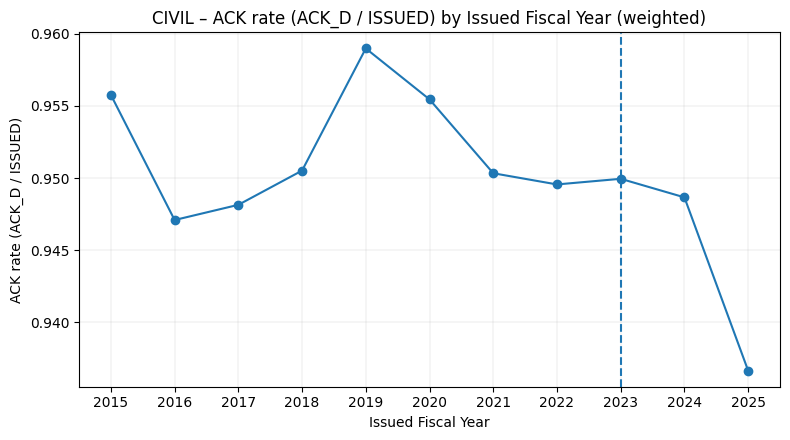

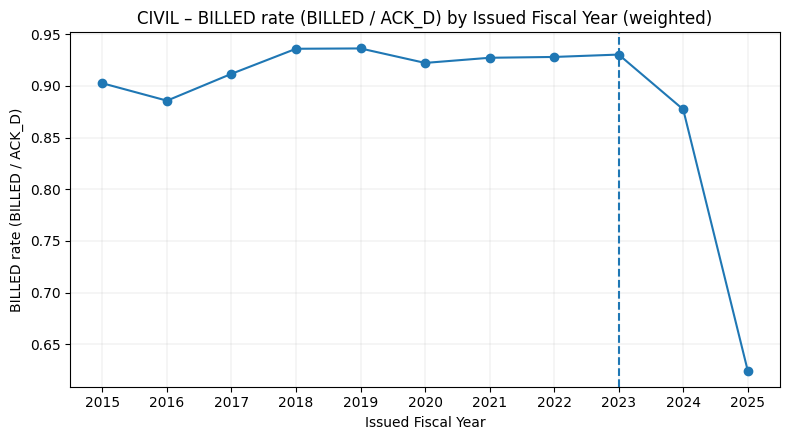

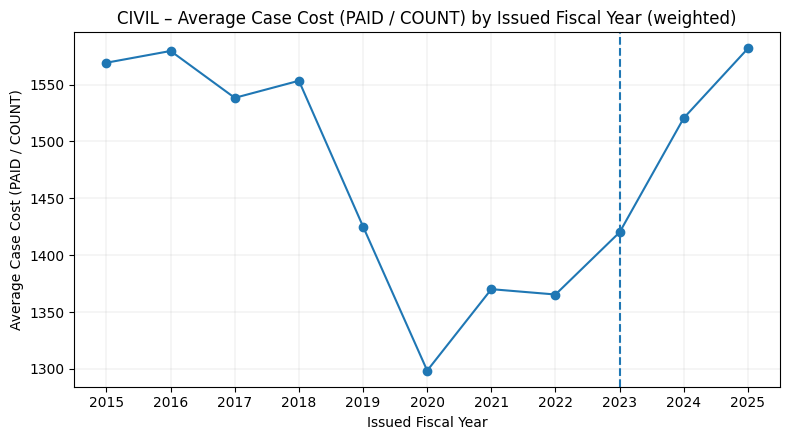

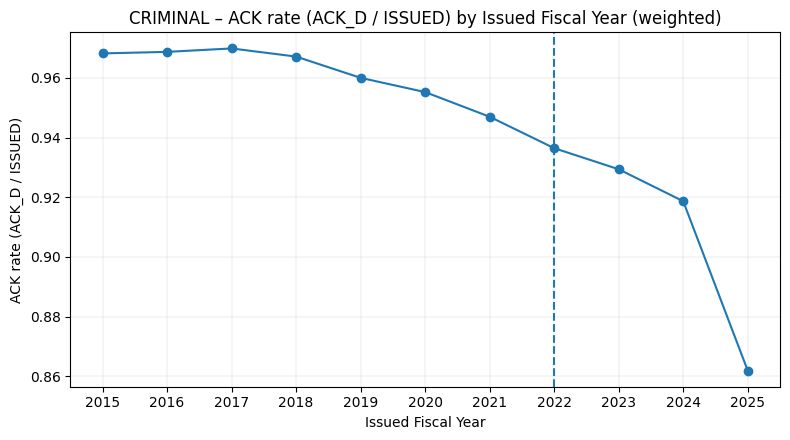

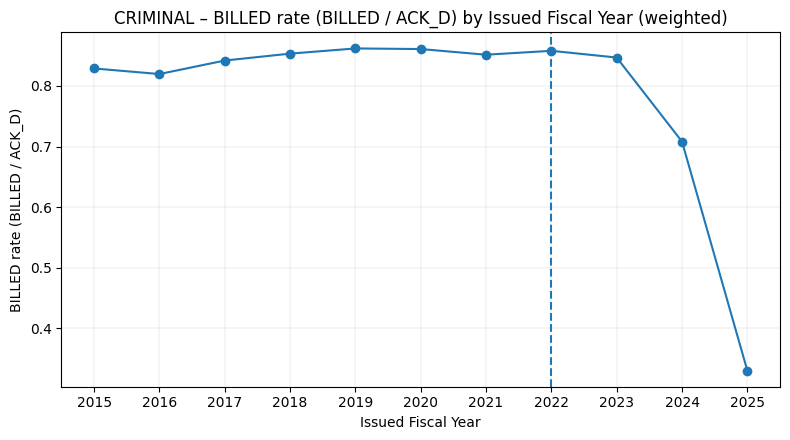

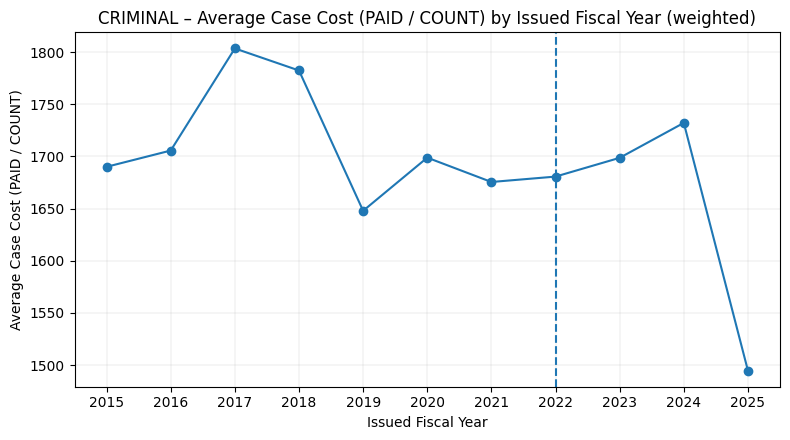

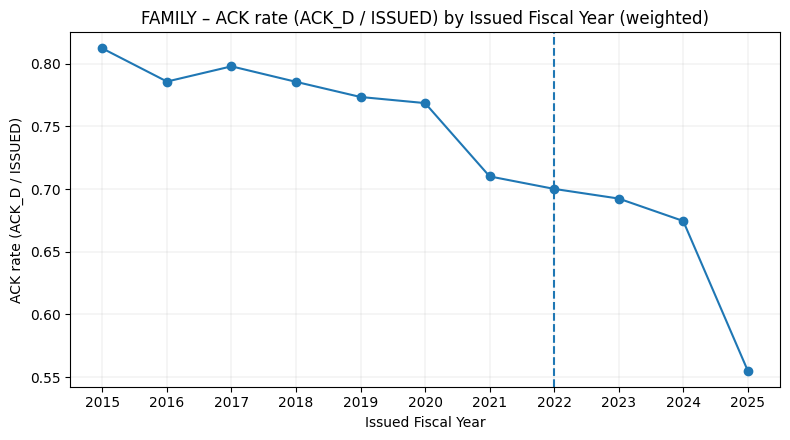

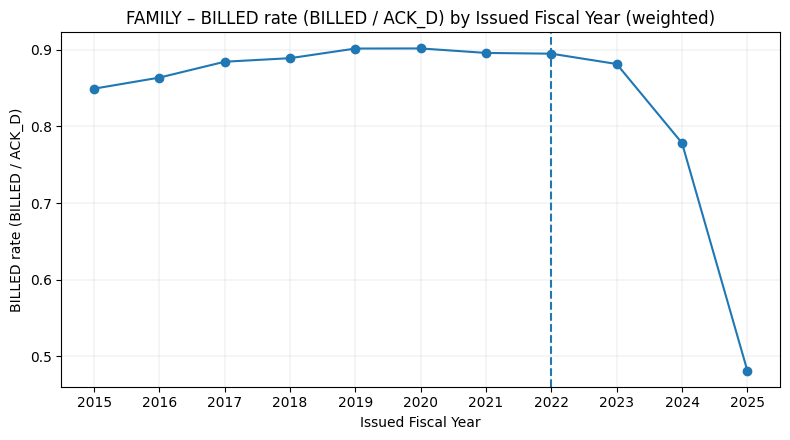

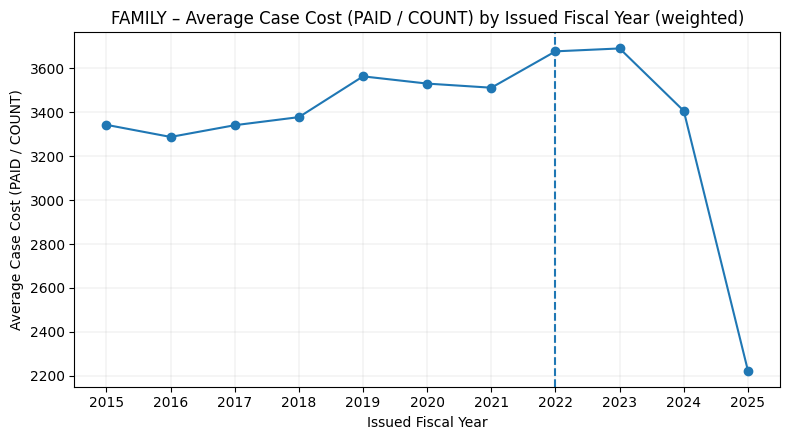

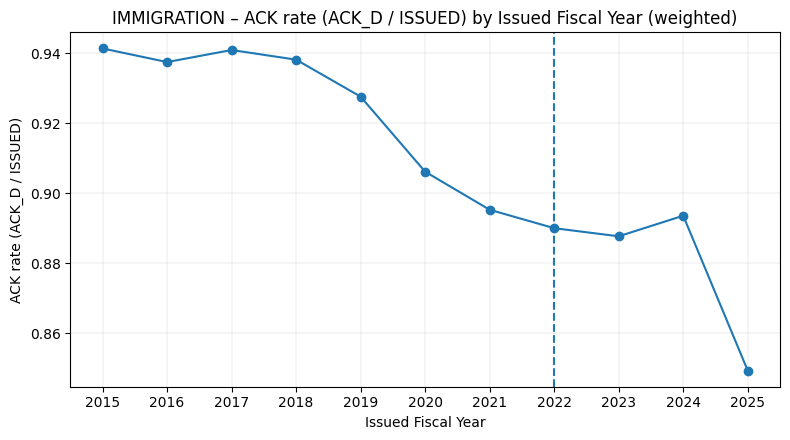

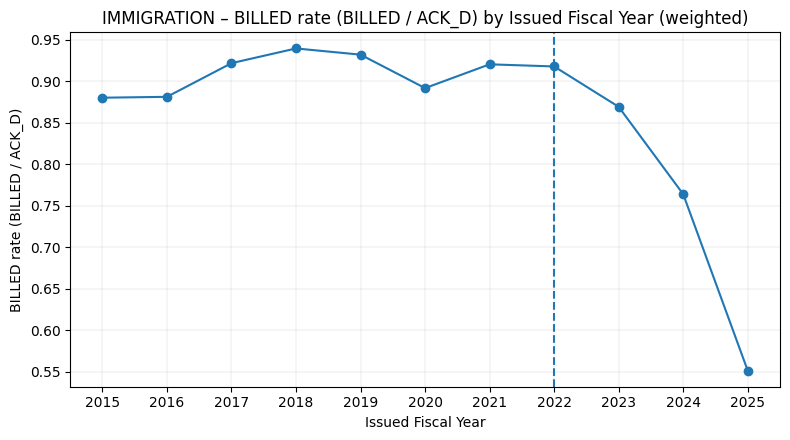

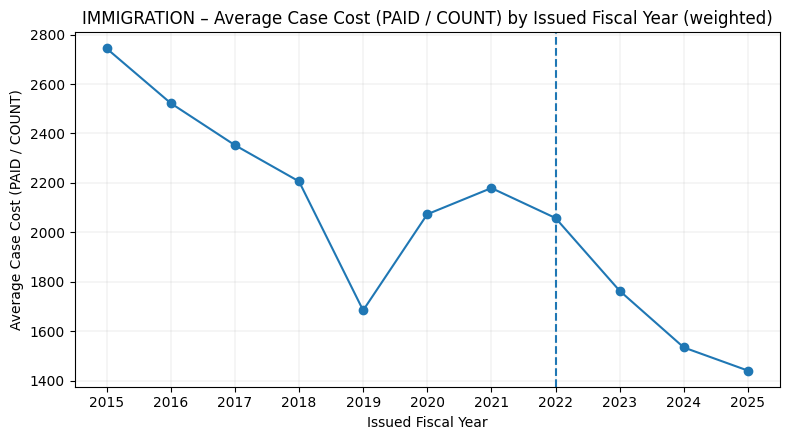

Done. PNG files saved to: \\Sherwood\accounting\Share\10 Unit Management Reporting & Systems\GitHub\Certificate_Forecasting_model\kpi_plots
Read inputs from: \\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\Certificate Forecast Dashboard\PowerBI\Inputs\Updates


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------
# Inputs folder (UNC path)
# -----------------------------
INPUT_DIR = Path(r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\Certificate Forecast Dashboard\PowerBI\Inputs\Updates")

ACK_FILE = INPUT_DIR / "Input 2.1 - Ack'ed - Billed.csv"
CC_FILE  = INPUT_DIR / "Input 2.2 - KPIs_CC.csv"

# Output folder for PNGs (creates a local folder where you run the script)
OUT_DIR = Path("kpi_plots")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Base=Lock years (as used in the plots)
BASE_YEARS = {
    "CRIMINAL": 2022,
    "FAMILY": 2022,
    "IMMIGRATION": 2022,
    "CIVIL": 2023,
}

# Toggle showing plots in a window
SHOW_PLOTS = True

# -----------------------------
# Load
# -----------------------------
ack = pd.read_csv(ACK_FILE)
cc = pd.read_csv(CC_FILE)

# -----------------------------
# Weighted yearly rates/costs by MAJOR
# -----------------------------
ack_year = (
    ack.groupby(["MAJOR", "FISCAL_YEAR"], as_index=False)
       .agg({"ISSUED": "sum", "ACK_D": "sum", "BILLED": "sum"})
)
ack_year["ACK_RATE"] = ack_year["ACK_D"] / ack_year["ISSUED"]
ack_year["BILLED_RATE"] = ack_year["BILLED"] / ack_year["ACK_D"]

cc_year = (
    cc.groupby(["MAJOR", "FY_I"], as_index=False)
      .agg({"PAID": "sum", "COUNT": "sum"})
      .rename(columns={"FY_I": "FISCAL_YEAR"})
)
cc_year["CC"] = cc_year["PAID"] / cc_year["COUNT"]

# -----------------------------
# Plot helper
# -----------------------------
def plot_major(df, major, metric_col, ylabel, base_year, out_path: Path, show_plots=True):
    d = df[df["MAJOR"] == major].sort_values("FISCAL_YEAR").copy()
    if d.empty:
        print(f"[SKIP] No data for {major} – {metric_col}")
        return

    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.plot(d["FISCAL_YEAR"], d[metric_col], marker="o")
    ax.axvline(base_year, linestyle="--")
    ax.set_title(f"{major} – {ylabel} by Issued Fiscal Year (weighted)")
    ax.set_xlabel("Issued Fiscal Year")
    ax.set_ylabel(ylabel)
    ax.set_xticks(sorted(d["FISCAL_YEAR"].unique()))
    ax.grid(True, linewidth=0.3, alpha=0.6)
    fig.tight_layout()

    fig.savefig(out_path, dpi=200)

    if show_plots:
        plt.show()   # shows the figure window

    plt.close(fig)   # closes after showing (or immediately if show_plots=False)

# -----------------------------
# Generate plots
# -----------------------------
majors = sorted(set(ack_year["MAJOR"]).union(set(cc_year["MAJOR"])))

for major in majors:
    if major not in BASE_YEARS:
        continue
    base_year = BASE_YEARS[major]

    plot_major(
        ack_year, major,
        metric_col="ACK_RATE",
        ylabel="ACK rate (ACK_D / ISSUED)",
        base_year=base_year,
        out_path=OUT_DIR / f"{major}_ACK_RATE.png",
        show_plots=SHOW_PLOTS
    )

    plot_major(
        ack_year, major,
        metric_col="BILLED_RATE",
        ylabel="BILLED rate (BILLED / ACK_D)",
        base_year=base_year,
        out_path=OUT_DIR / f"{major}_BILLED_RATE.png",
        show_plots=SHOW_PLOTS
    )

    plot_major(
        cc_year, major,
        metric_col="CC",
        ylabel="Average Case Cost (PAID / COUNT)",
        base_year=base_year,
        out_path=OUT_DIR / f"{major}_CC.png",
        show_plots=SHOW_PLOTS
    )

print(f"Done. PNG files saved to: {OUT_DIR.resolve()}")
print(f"Read inputs from: {INPUT_DIR}")
